In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-taxi-trip-duration/train.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip


In [3]:
import os
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
import torch
import warnings
warnings.filterwarnings('ignore')

In [73]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
N_THREADS = 4
N_FOLDS = 5
TIMEOUT = 600

In [6]:
np.random.seed(RANDOM_STATE)

In [7]:
df=pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.zip')
test=pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.zip')
df_sample=pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip')

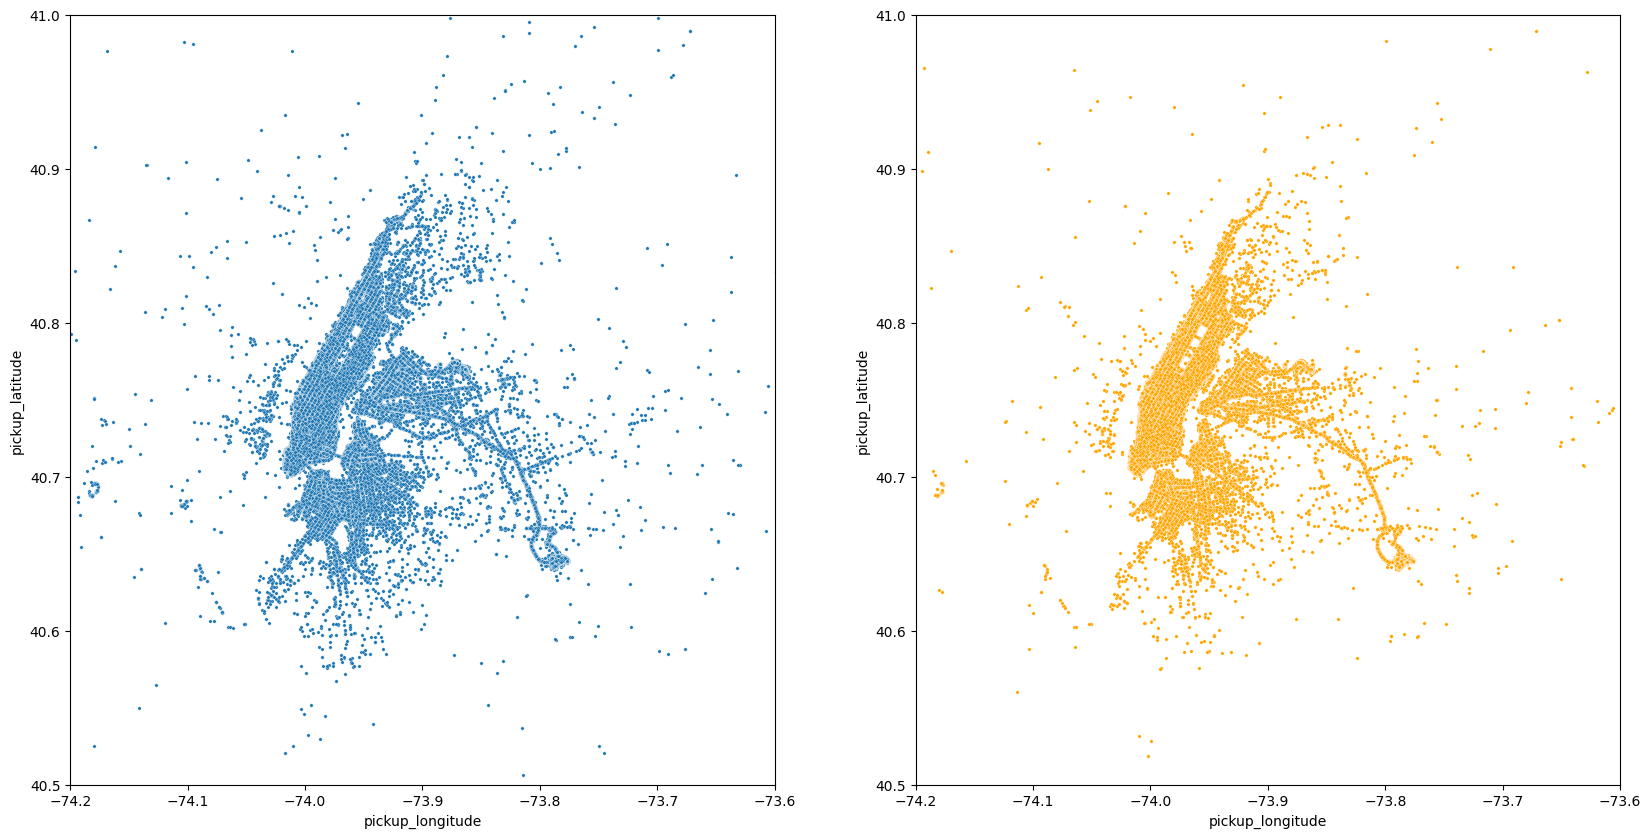

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.scatterplot(x = df['pickup_longitude'], y = df['pickup_latitude'], s=6, ax=ax[0])
ax[0].set_xlim([-74.2, -73.6])
ax[0].set_ylim([40.5, 41.0])

sns.scatterplot(x = test['pickup_longitude'], y = test['pickup_latitude'], s=6, ax=ax[1], color='orange')
ax[1].set_xlim([-74.2, -73.6])
ax[1].set_ylim([40.5, 41.0])
plt.show()

In [9]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000
mean,1.53495,1.66453,-73.97349,40.75092,-73.97342,40.75180,959.49227
std,0.49878,1.31424,0.07090,0.03288,0.07064,0.03589,5237.43172
min,1.00000,0.00000,-121.93334,34.35970,-121.93330,32.18114,1.00000
25%,1.00000,1.00000,-73.99187,40.73735,-73.99133,40.73588,397.00000
50%,2.00000,1.00000,-73.98174,40.75410,-73.97975,40.75452,662.00000
75%,2.00000,2.00000,-73.96733,40.76836,-73.96301,40.76981,1075.00000
max,2.00000,9.00000,-61.33553,51.88108,-61.33553,43.92103,3526282.00000


In [10]:
df = df[df.pickup_longitude.between(-75, -71) & df.dropoff_longitude.between(-75, -71)]

In [11]:
!pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16675 sha256=f1fc8a5740dca9e06c509701413db5b39e955bb50fdce4afe2980f57e6c882a2
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
from math import radians, cos, sin, asin, sqrt

def havesine(data):
    lon1 = data['pickup_longitude']
    lat1 = data['pickup_latitude']
    lon2 = data['dropoff_longitude']
    lat2 = data['dropoff_latitude']

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))

    r = 6371
    return c * r

In [13]:
df['distance_geo'] = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].parallel_apply(havesine, axis=1)

In [14]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['pickup_weekend'] = df['pickup_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [15]:
df['store_and_fwd_flag'] = 1 * (df.store_and_fwd_flag == 'Y')

In [16]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

In [17]:
df['date'] = df['pickup_datetime'].dt.date
df['pickup_holiday'] = df['date'].isin(holidays)
df['pickup_holiday'] = df['pickup_holiday'].map(lambda x: 1 if x == True else 0)

df['pickup_near_holiday'] = df['date'].isin(holidays + timedelta(
    days=1))| df['date'].isin(holidays - timedelta(days=1))
df['pickup_near_holiday'] = df['pickup_near_holiday'].map(lambda x: 1 if x == True else 0)

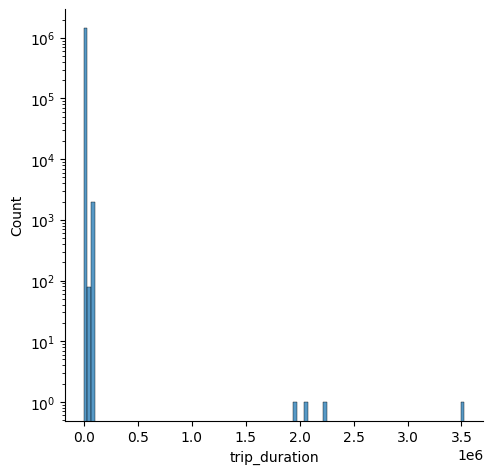

In [18]:
sns.displot(df['trip_duration'], bins=100)
plt.yscale('log')

In [19]:
df = df.assign(log_trip_duration=np.log(df['trip_duration'] + 1))

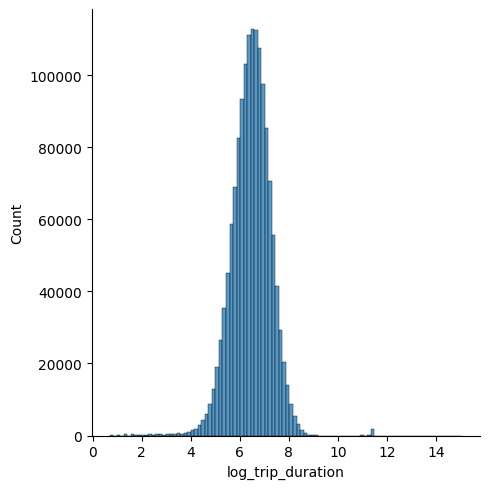

In [20]:
sns.displot(df['log_trip_duration'], bins=100)

In [21]:
df = df[~df.passenger_count.isin([0, 7, 8, 9])]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458547 entries, 0 to 1458643
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   1458547 non-null  object        
 1   vendor_id            1458547 non-null  int64         
 2   pickup_datetime      1458547 non-null  datetime64[ns]
 3   dropoff_datetime     1458547 non-null  object        
 4   passenger_count      1458547 non-null  int64         
 5   pickup_longitude     1458547 non-null  float64       
 6   pickup_latitude      1458547 non-null  float64       
 7   dropoff_longitude    1458547 non-null  float64       
 8   dropoff_latitude     1458547 non-null  float64       
 9   store_and_fwd_flag   1458547 non-null  int64         
 10  trip_duration        1458547 non-null  int64         
 11  distance_geo         1458547 non-null  float64       
 12  pickup_month         1458547 non-null  int32         
 13  pi

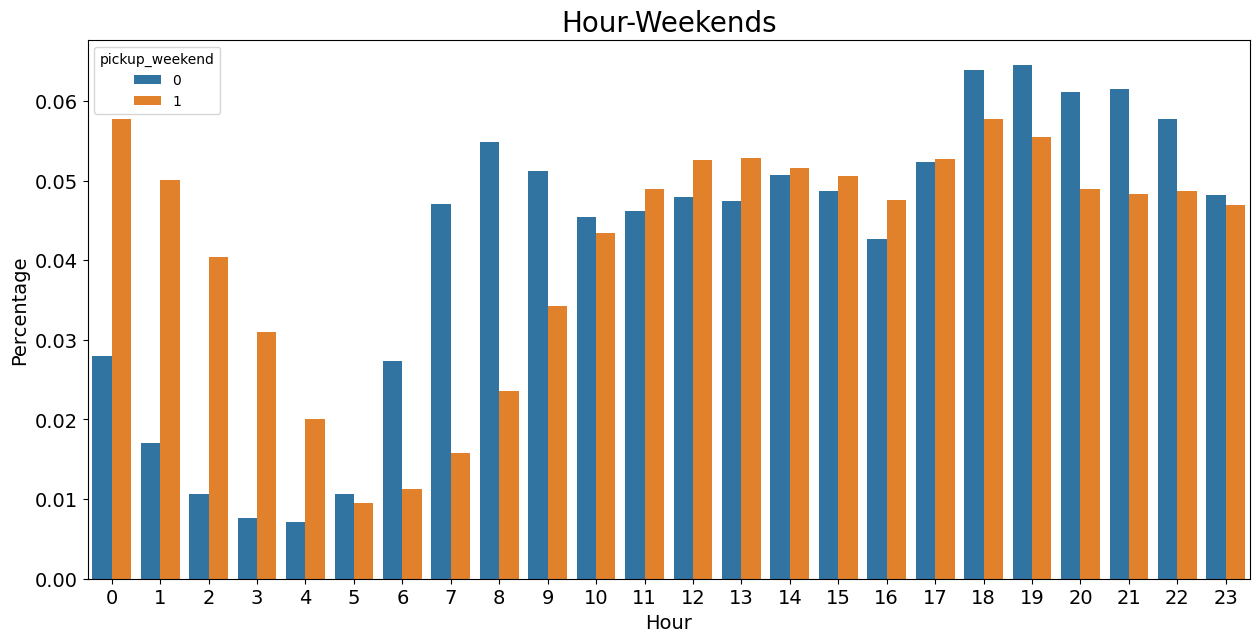

In [23]:
norm_hours = (df.groupby(['pickup_weekend'])['pickup_hour']
             .value_counts(normalize=True)
             .rename('percentage')
             .reset_index()
             .sort_values('pickup_hour'))
plt.figure(figsize=(15, 7))
ax = sns.barplot(x='pickup_hour', y='percentage', hue='pickup_weekend', data=norm_hours)

plt.title('Hour-Weekends', fontsize=20)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Hour', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

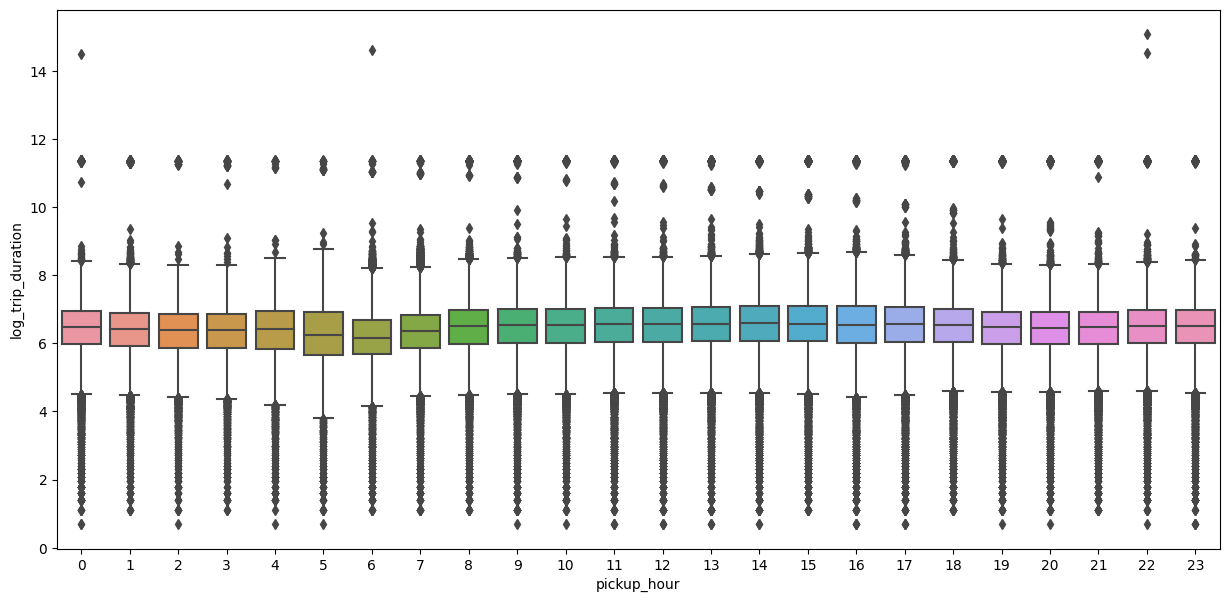

In [24]:
plt.figure(figsize=(15, 7))
sns.boxplot(x='pickup_hour', y='log_trip_duration', data=df)
plt.show()

In [25]:
df = df.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'date'], axis=1)

In [26]:
df = df.drop(['distance_geo', 'trip_duration'], axis=1)

In [27]:
X = df.drop('log_trip_duration', axis=1)
y = df['log_trip_duration']

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [29]:
from sklearn.metrics import mean_squared_log_error
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [30]:
!pip install optuna-integration[lightgbm]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 2.4 MB/s eta 0:00:00a 0:00:01


In [31]:
!pip install lightgbm

In [47]:
from sklearn.model_selection import KFold
import lightgbm as lg 
def objective(trial, X, y):
    param_grid = {
        'n_estimators' : trial.suggest_categorical('n_estimators', [1000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves' : trial.suggest_int('num_leaves', 20, 300, step=50),
        'max_depth' : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200, step=30)
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    cv_predicts = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'l2')
        model = lg.LGBMRegressor(objective='regression', **param_grid)
        model.fit(X_train,
             y_train,
             eval_set=[(X_test, y_test)],
             eval_metric='rmsle',
             callbacks=[pruning_callback])
        preds = model.predict(X_test)
        cv_predicts[idx] = rmsle(y_test, preds)

    return np.mean(cv_predicts)

In [48]:
import optuna
study = optuna.create_study(direction='minimize', study_name='LGB')
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=2)

[I 2025-01-07 20:07:24,262] A new study created in memory with name: LGB


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 933469, number of used features: 9
[LightGBM] [Info] Start training from score 6.466398
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 933469, number of used features: 9
[LightGBM] [Info] Start training from score 6.466722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

[I 2025-01-07 20:09:47,318] Trial 0 finished with value: 0.11196861426300704 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2334136282314777, 'num_leaves': 20, 'max_depth': 9, 'min_child_samples': 95}. Best is trial 0 with value: 0.11196861426300704.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 933469, number of used features: 9
[LightGBM] [Info] Start training from score 6.466398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-01-07 20:14:21,185] Trial 1 finished with value: 0.11222350410721094 and parameters: {'n_estimators': 1000, 'learning_rate': 0.16315944081262673, 'num_leaves': 70, 'max_depth': 7, 'min_child_samples': 125}. Best is trial 0 with value: 0.11196861426300704.


In [49]:
print(f'Best value (rmsle) : {study.best_value:.5f}')
print(f'Best params:')

for key, value in study.best_params.items():
    print(f'\t{key}: {value}')

Best value (rmsle) : 0.11197
Best params:
	n_estimators: 1000
	learning_rate: 0.2334136282314777
	num_leaves: 20
	max_depth: 9
	min_child_samples: 95


In [50]:
study.best_params

{'n_estimators': 1000,
 'learning_rate': 0.2334136282314777,
 'num_leaves': 20,
 'max_depth': 9,
 'min_child_samples': 95}

<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

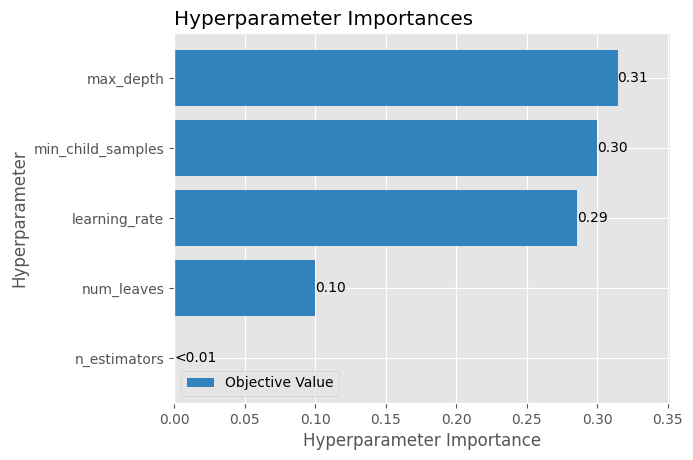

In [51]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study)

In [53]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
finish_test_preds = []
cv_predicts = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = lg.LGBMRegressor(objective='regression', **study.best_params)
    model.fit(X_train_,
         y_train_,
         eval_set=[(X_val, y_val)],
         eval_metric='rmsle')
    preds = model.predict(X_val)
    preds_exp = np.exp(preds) - 1
    y_val_exp = np.exp(y_val) - 1
    
    cv_predicts[idx] = rmsle(y_val_exp, preds_exp)
    preds_test = model.predict(X_test)
    finish_test_preds.append(preds_test)
    print(f'id = {idx}', cv_predicts[idx], '\n')
    
print(np.mean(cv_predicts))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 746775, number of used features: 9
[LightGBM] [Info] Start training from score 6.466829
id = 0 0.7862903887976038 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 746775, number of used features: 9
[LightGBM] [Info] Start training from score 6.466344
id = 1 0.7865988104828078 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034111 seconds.
You can set `force_row_wise=tr

In [55]:
test_pred = np.mean(np.column_stack(finish_test_preds), axis=1)
test_pred_exp = np.exp(test_pred.data) - 1

y_test_exp = np.exp(y_test.values) - 1

print(f'OOF score: {np.mean(cv_predicts)}')
print(f'HOLDOUT score: {rmsle(y_test_exp, test_pred_exp)}')

OOF score: 0.7855597243564356
HOLDOUT score: 0.7804158496886393


In [56]:
!pip install lightautoml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.6/399.6 kB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 82.7 MB/s eta 0:00:00:00:010:01
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7591 sha256=7b30fdac539de2971fd861242a688ecd6c22f582ddc54d5a3dcac4b49ef78538
  Stored in directory: /root/.cache/pip/wheels/e0/d8/b3/6f83a04ab0ec00e691de794d108286bb0f8bcdf4ade19afb57
Successfully built json2html
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.3
    Uninstalling statsmodels-0.14.3:
      Successfully uninstalled statsmodels-0.14.3


In [57]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import torch

torch.set_num_threads(N_THREADS)

In [60]:
tr_data, te_data = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [61]:
task = Task('reg', loss='rmsle', metric='rmsle')

In [62]:
roles = {
    'target' : 'log_trip_duration'
}

In [74]:
automl = TabularAutoML(task=task,
                      timeout=TIMEOUT,
                      cpu_limit=N_THREADS,
                      reader_params={
                          'n_jobs' : N_THREADS,
                          'cv' : N_FOLDS,
                          'random_state': RANDOM_STATE,
                          'verbose' : 1
                      })

In [ ]:
oof_pred = automl.fit_predict(tr_data, roles=roles, verbose=1)

[20:46:01] Stdout logging level is INFO.
[20:46:01] Task: reg

[20:46:01] Start automl preset with listed constraints:
[20:46:01] - time: 600.00 seconds
[20:46:01] - CPU: 4 cores
[20:46:01] - memory: 16 GB

[20:46:01] Train data shape: (1093910, 12)

[20:46:09] Layer 1 train process start. Time left 591.40 secs
[20:46:14] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[20:46:29] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.11203242586849614
[20:46:29] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[20:46:29] Time left 572.06 secs

[20:46:41] Selector_LightGBM fitting and predicting completed
[20:46:46] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


In [65]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.47445 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.08306 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.44249 * (1 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


In [68]:
oof_pred_exp = np.exp(oof_pred.data[:, 0]) - 1

test_pred = automl.predict(te_data)
test_pred_exp = np.exp(test_pred.data[:, 0]) - 1

In [72]:
print(rmsle(tr_data['log_trip_duration'], oof_pred_exp))

4.421511171153695


In [70]:
tr_data

,vendor_id,passenger_count,store_and_fwd_flag,pickup_month,pickup_day,pickup_dayofweek,pickup_hour,pickup_minute,pickup_weekend,pickup_holiday,pickup_near_holiday,log_trip_duration
788926,1,1,0,1,13,2,4,0,0,0,0,6.87833
1432195,1,1,0,2,7,6,16,52,1,0,0,6.18826
1370956,1,1,0,4,20,2,20,35,0,0,0,5.76832
449694,1,1,0,5,22,6,18,47,1,0,0,5.50533
942295,1,1,0,1,1,4,21,9,0,0,0,7.55538
...,...,...,...,...,...,...,...,...,...,...,...,...
259186,2,1,0,3,5,5,18,25,1,0,0,6.08904
1414505,2,1,0,4,10,6,19,55,1,0,0,6.38856
131934,1,2,0,4,30,5,17,54,1,0,0,7.17396
671190,2,1,0,2,7,6,12,6,1,0,0,6.19644
